# Коэффициент восстановления золота из золотосодержащей руды

Компания "Цифра" разрабатывает решения для эффективной работы промышленных предприятий. Необходимо оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении есть данные с параметрами добычи и очистки.

## Описание данных

**Технологический процесс:**

Rougher feed — исходное сырье

Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant

Xanthate — ксантогенат (промотер, или активатор флотации);

Sulphate — сульфат (на данном производстве сульфид натрия);

Depressant — депрессант (силикат натрия).

Rougher process (англ. «грубый процесс») — флотация

Rougher tails — отвальные хвосты

Float banks — флотационная установка

Cleaner process — очистка

Rougher Au — черновой концентрат золота

Final Au — финальный концентрат золота


**Параметры этапов:**

air amount — объём воздуха

fluid levels — уровень жидкости

feed size — размер гранул сырья

feed rate — скорость подачи

## Наименование признаков

[этап].[тип_параметра].[название_параметра]

**Пример:** rougher.input.feed_ag

**Возможные значения для блока [этап]:**

rougher — флотация

primary_cleaner — первичная очистка

secondary_cleaner — вторичная очистка

final — финальные характеристики

**Возможные значения для блока [тип_параметра]:**

input — параметры сырья

output — параметры продукта

state — параметры, характеризующие текущее состояние этапа

calculation — расчётные характеристики

## Расчет эффективности

Нам нужно смоделировать процесс восстановления золота из золотосодержащей руды.
Эффективность обогащения рассчитывается по формуле:

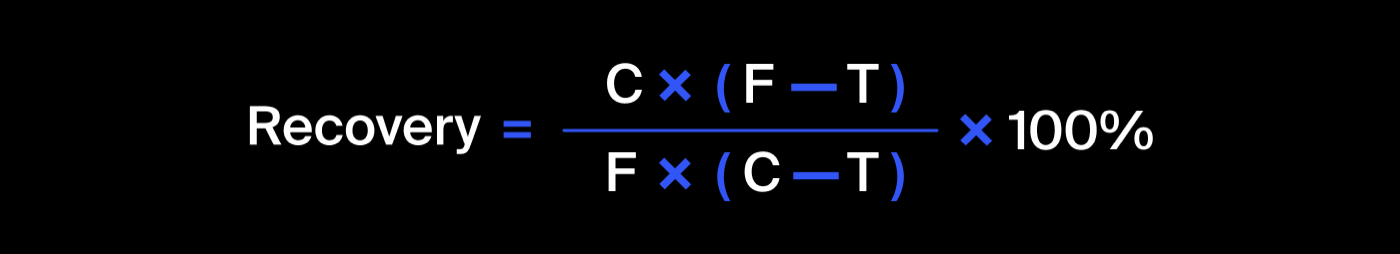

где:
C — доля золота в концентрате после флотации/очистки;
F — доля золота в сырье/концентрате до флотации/очистки;
T — доля золота в отвальных хвостах после флотации/очистки.
Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

## Метрика качества

Для решения задачи введём новую метрику качества — **sMAPE** (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.
Метрика sMAPE вычисляется так:

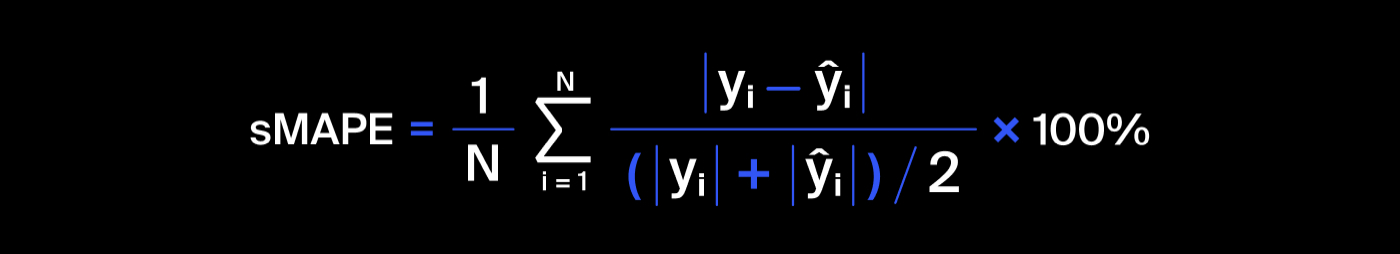

## Шаги

- Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery.
- Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
- Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

## Загрузка и подготовка данных

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import ttest_ind
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from random import randint
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
import seaborn as sns

In [5]:
RANDOM_STATE = 12345
ALPHA = 0.05

In [6]:
full_df = pd.read_csv('datasets/gold_recovery_full_new.csv')
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [7]:
train_df = pd.read_csv('datasets/gold_recovery_train_new.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [8]:
test_df = pd.read_csv('datasets/gold_recovery_test_new.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

1. Колонка date - строковая, все остальные имеют тип float.
2. Есть пропуски в колонках.
3. В тестовой выборке нет некоторых признаков, имеющихся в обучающей выборке.

In [9]:
def recovery_share(c, f, t):
    recovery_share = (c * (f - t)) / (f * (c - t)) * 100
    return recovery_share

In [10]:
y_true = train_df['rougher.output.recovery']

c = train_df['rougher.output.concentrate_au']
f = train_df['rougher.input.feed_au']
t = train_df['rougher.output.tail_au']
y_pred = recovery_share(c, f, t)

mae = mean_absolute_error(y_true, y_pred)
mae

9.73512347450521e-15

MAE показало наличие разницы между эффективностью обогащения в обучающей выборке и расчетами по формуле. Но эта разница небольшая.

In [11]:
out_test_columns = set(train_df.columns) - set(test_df.columns) - set(['rougher.output.recovery', 'final.output.recovery'])
unnecessary_columns = list(out_test_columns)
unnecessary_columns

['final.output.concentrate_ag',
 'rougher.output.concentrate_ag',
 'final.output.tail_au',
 'rougher.calculation.au_pb_ratio',
 'secondary_cleaner.output.tail_au',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'secondary_cleaner.output.tail_ag',
 'rougher.output.concentrate_pb',
 'final.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'final.output.tail_sol',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.output.concentrate_au',
 'secondary_cleaner.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'rougher.output.tail_au',
 'final.output.tail_pb',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.concentrate_sol',
 'rougher.output.concentrate_sol',
 'primary_cleaner.output.concentrate_pb',
 '

В тестовой выборке недоступны параметры продукта после выхода из каждого этапа. Они нам не нужны, так как могут быть посчитаны только после завершения процесса очистки - удалим эти параметры из обучающей выборки.

In [12]:
train_df = train_df.drop(unnecessary_columns, axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        14149 non-null  object 
 1   final.output.recovery                       14149 non-null  float64
 2   primary_cleaner.input.sulfate               14129 non-null  float64
 3   primary_cleaner.input.depressant            14117 non-null  float64
 4   primary_cleaner.input.feed_size             14149 non-null  float64
 5   primary_cleaner.input.xanthate              14049 non-null  float64
 6   primary_cleaner.state.floatbank8_a_air      14145 non-null  float64
 7   primary_cleaner.state.floatbank8_a_level    14148 non-null  float64
 8   primary_cleaner.state.floatbank8_b_air      14145 non-null  float64
 9   primary_cleaner.state.floatbank8_b_level    14148 non-null  float64
 10  primary_cl

В тестовой выборке также отсутствуют целевые признаки. Добавим их из полной выборки.

In [13]:
test_df['rougher.output.recovery'] = full_df.loc[test_df.index]['rougher.output.recovery']
test_df['rougher.output.recovery'].head()

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64

In [14]:
test_df['final.output.recovery'] = full_df.loc[test_df.index]['final.output.recovery']
test_df['final.output.recovery'].head()

0    70.541216
1    69.266198
2    68.116445
3    68.347543
4    66.927016
Name: final.output.recovery, dtype: float64

In [15]:
test_df.columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

## Обработка пропусков

### Тестовая выборка

В тестовой выборке нужно удалить все пропуски, чтобы получить корректный тест.

In [16]:
# Поиск нулевых значений
print('Длина тестовой выборки до удаления пропусков:', test_df.shape[0])
test_df['rougher.output.recovery'] = test_df[test_df['rougher.output.recovery'] != 0]['rougher.output.recovery']
test_df['final.output.recovery'] = test_df[test_df['final.output.recovery'] != 0]['final.output.recovery']
print(test_df['rougher.output.recovery'].isna().sum())
print(test_df['final.output.recovery'].isna().sum())

Длина тестовой выборки до удаления пропусков: 5290
96
23


In [17]:
test_df = test_df.dropna()
print('Длина тестовой выборки после удаления нулевых целевых признаков:', test_df.shape[0])

Длина тестовой выборки после удаления нулевых целевых признаков: 5113


### Обучающая выборка

In [18]:
print('Длина обучающей выборки до удаления нулевых целевых признаков:', train_df.shape[0])
train_df['rougher.output.recovery'] = train_df[train_df['rougher.output.recovery'] != 0]['rougher.output.recovery']
train_df['final.output.recovery'] = train_df[train_df['final.output.recovery'] != 0]['final.output.recovery']
print(train_df['rougher.output.recovery'].isna().sum())
print(train_df['final.output.recovery'].isna().sum())

Длина обучающей выборки до удаления нулевых целевых признаков: 14149
297
58


In [19]:
train_df = train_df.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
print('Длина обучающей выборки после удаления нулевых целевых признаков:', train_df.shape[0])

Длина обучающей выборки после удаления нулевых целевых признаков: 13795


In [20]:
train_df.isna().sum()

date                                            0
final.output.recovery                           0
primary_cleaner.input.sulfate                  19
primary_cleaner.input.depressant               26
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                 96
primary_cleaner.state.floatbank8_a_air          4
primary_cleaner.state.floatbank8_a_level        1
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_b_level        1
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_c_level        1
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_d_level        1
rougher.input.feed_ag                           0
rougher.input.feed_pb                         100
rougher.input.feed_rate                         8
rougher.input.feed_size                       139
rougher.input.feed_sol                         75
rougher.input.feed_au                           0


In [21]:
# Заполним пропуски соседними значениями
train_df = train_df.fillna(method='bfill')
train_df.isna().sum()

date                                          0
final.output.recovery                         0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate       

## Анализ данных

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13795 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        13795 non-null  object 
 1   final.output.recovery                       13795 non-null  float64
 2   primary_cleaner.input.sulfate               13795 non-null  float64
 3   primary_cleaner.input.depressant            13795 non-null  float64
 4   primary_cleaner.input.feed_size             13795 non-null  float64
 5   primary_cleaner.input.xanthate              13795 non-null  float64
 6   primary_cleaner.state.floatbank8_a_air      13795 non-null  float64
 7   primary_cleaner.state.floatbank8_a_level    13795 non-null  float64
 8   primary_cleaner.state.floatbank8_b_air      13795 non-null  float64
 9   primary_cleaner.state.floatbank8_b_level    13795 non-null  float64
 10  primary_cl

### Концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [23]:
print('Размер полной выборки:', full_df.shape[0])

Размер полной выборки: 19439


In [24]:
full_df_new = full_df.dropna()
print('Размер полной выборки без пропусков:', full_df_new.shape[0])

Размер полной выборки без пропусков: 16094


In [25]:
stages = [
    'rougher.input.feed',
    'rougher.output.concentrate',
    'rougher.output.tail',
    'primary_cleaner.output.concentrate',
    'primary_cleaner.output.tail',
    'secondary_cleaner.output.tail',
    'final.output.concentrate',
    'final.output.tail'
]

metal_columns = {
    'au': [],
    'ag': [],
    'pb': [],
    'sol': []
}

for key in metal_columns:
    for c in stages:
        metal_columns[key].append(f'{c}_{key}')

metal_columns

{'au': ['rougher.input.feed_au',
  'rougher.output.concentrate_au',
  'rougher.output.tail_au',
  'primary_cleaner.output.concentrate_au',
  'primary_cleaner.output.tail_au',
  'secondary_cleaner.output.tail_au',
  'final.output.concentrate_au',
  'final.output.tail_au'],
 'ag': ['rougher.input.feed_ag',
  'rougher.output.concentrate_ag',
  'rougher.output.tail_ag',
  'primary_cleaner.output.concentrate_ag',
  'primary_cleaner.output.tail_ag',
  'secondary_cleaner.output.tail_ag',
  'final.output.concentrate_ag',
  'final.output.tail_ag'],
 'pb': ['rougher.input.feed_pb',
  'rougher.output.concentrate_pb',
  'rougher.output.tail_pb',
  'primary_cleaner.output.concentrate_pb',
  'primary_cleaner.output.tail_pb',
  'secondary_cleaner.output.tail_pb',
  'final.output.concentrate_pb',
  'final.output.tail_pb'],
 'sol': ['rougher.input.feed_sol',
  'rougher.output.concentrate_sol',
  'rougher.output.tail_sol',
  'primary_cleaner.output.concentrate_sol',
  'primary_cleaner.output.tail_sol',


In [26]:
# Золото
au_df = full_df_new[metal_columns['au']].rename(columns={
    'rougher.input.feed_au': 'rougher.input.feed',
    'rougher.output.concentrate_au': 'rougher.output.concentrate',
    'rougher.output.tail_au': 'rougher.output.tail',
    'primary_cleaner.output.concentrate_au': 'primary_cleaner.output.concentrate',
    'primary_cleaner.output.tail_au': 'primary_cleaner.output.tail',
    'secondary_cleaner.output.tail_au': 'secondary_cleaner.output.tail',
    'final.output.concentrate_au': 'final.output.concentrate',
    'final.output.tail_au': 'final.output.tail'
})

au_mean_series = au_df.mean()
au_df.head()

,rougher.input.feed,rougher.output.concentrate,rougher.output.tail,primary_cleaner.output.concentrate,primary_cleaner.output.tail,secondary_cleaner.output.tail,final.output.concentrate,final.output.tail
0,6.486150,19.793808,1.170244,34.174427,2.106679,2.606185,42.192020,2.143149
1,6.478583,20.050975,1.184827,34.118526,2.353017,2.488248,42.701629,2.224930
2,6.362222,19.737170,1.162562,33.969464,2.416800,2.458187,42.657501,2.257889
3,6.118189,19.320810,1.079755,28.260743,2.262051,2.322062,42.689819,2.146849
4,5.663707,19.216101,1.012642,33.044932,2.277073,2.330448,42.774141,2.055292


In [27]:
# Серебро
ag_df = full_df_new[metal_columns['ag']].rename(columns={
    'rougher.input.feed_ag': 'rougher.input.feed',
    'rougher.output.concentrate_ag': 'rougher.output.concentrate',
    'rougher.output.tail_ag': 'rougher.output.tail',
    'primary_cleaner.output.concentrate_ag': 'primary_cleaner.output.concentrate',
    'primary_cleaner.output.tail_ag': 'primary_cleaner.output.tail',
    'secondary_cleaner.output.tail_ag': 'secondary_cleaner.output.tail',
    'final.output.concentrate_ag': 'final.output.concentrate',
    'final.output.tail_ag': 'final.output.tail'
})
ag_mean_series = ag_df.mean()

In [28]:
# Свинец
pb_df = full_df_new[metal_columns['pb']].rename(columns={
    'rougher.input.feed_pb': 'rougher.input.feed',
    'rougher.output.concentrate_pb': 'rougher.output.concentrate',
    'rougher.output.tail_pb': 'rougher.output.tail',
    'primary_cleaner.output.concentrate_pb': 'primary_cleaner.output.concentrate',
    'primary_cleaner.output.tail_pb': 'primary_cleaner.output.tail',
    'secondary_cleaner.output.tail_pb': 'secondary_cleaner.output.tail',
    'final.output.concentrate_pb': 'final.output.concentrate',
    'final.output.tail_pb': 'final.output.tail'
})

pb_mean_series = pb_df.mean()

In [29]:
# Другие примеси
sol_df = full_df_new[metal_columns['sol']].rename(columns={
    'rougher.input.feed_sol': 'rougher.input.feed',
    'rougher.output.concentrate_sol': 'rougher.output.concentrate',
    'rougher.output.tail_sol': 'rougher.output.tail',
    'primary_cleaner.output.concentrate_sol': 'primary_cleaner.output.concentrate',
    'primary_cleaner.output.tail_sol': 'primary_cleaner.output.tail',
    'secondary_cleaner.output.tail_sol': 'secondary_cleaner.output.tail',
    'final.output.concentrate_sol': 'final.output.concentrate',
    'final.output.tail_sol': 'final.output.tail'
})

sol_mean_series = sol_df.mean()

In [30]:
mean_df = pd.DataFrame(
    data={
        'au': au_mean_series,
        'ag': ag_mean_series,
        'pb': pb_mean_series,
        'sol': sol_mean_series
    },
    columns=[
        'au', 'ag', 'pb', 'sol'
    ]
)
mean_df

,au,ag,pb,sol
rougher.input.feed,8.516990,8.985281,3.636621,36.962618
rougher.output.concentrate,20.052152,12.084945,7.553095,29.115629
rougher.output.tail,1.878254,5.705731,0.651723,18.078687
primary_cleaner.output.concentrate,32.065559,8.674853,9.884018,10.747844
primary_cleaner.output.tail,3.950477,15.827367,3.325620,8.394998
secondary_cleaner.output.tail,4.359506,14.614602,5.518585,7.441037
final.output.concentrate,44.307437,5.190976,9.997593,9.871835
final.output.tail,3.127346,9.791784,2.771241,10.937692


<AxesSubplot:title={'center':'Изменение средней концентрации металлов в сырье/концентрате на различных этапах очистки'}, ylabel='Средняя концентрация металла'>

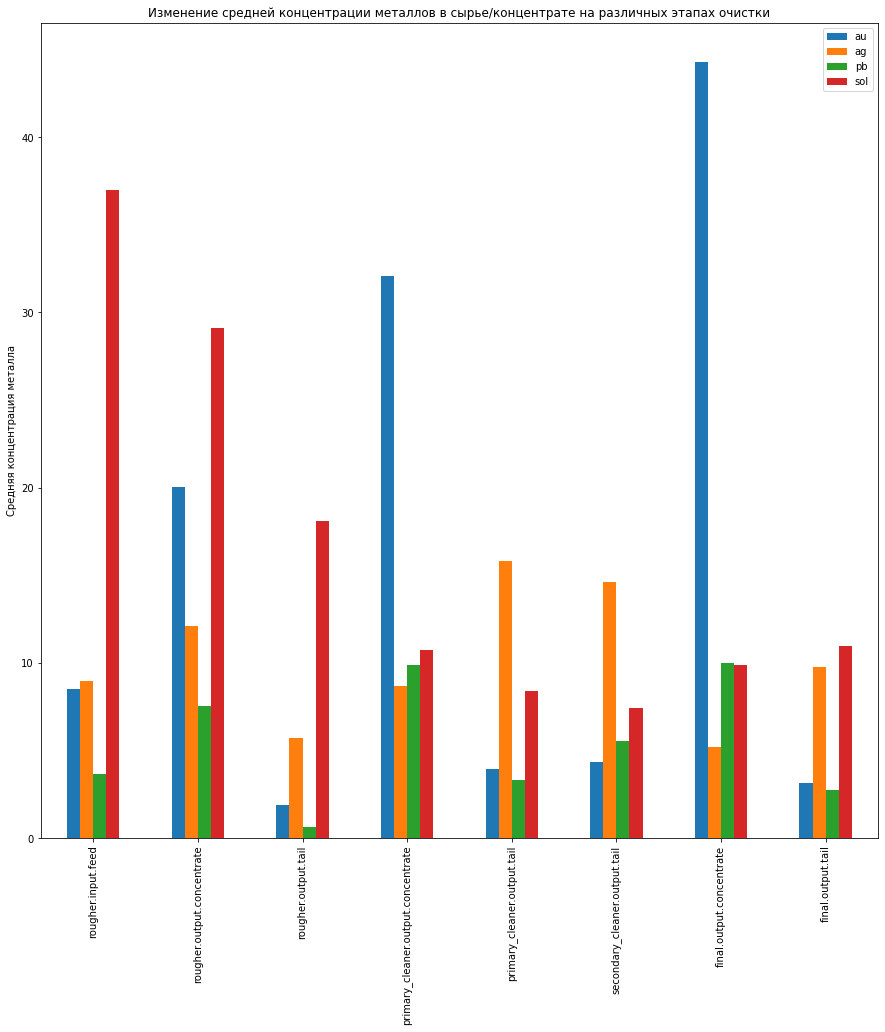

In [31]:
mean_df.plot(
    kind='bar',
    title='Изменение средней концентрации металлов в сырье/концентрате на различных этапах очистки',
    figsize=(15, 15),
    ylabel='Средняя концентрация металла'
)

Средняя концентрация золота на различных этапах очистки растет. Средняя концентрация серебра, свинца и других примесей падает, но небольшая их доля остается в финальном концентрате.

In [32]:
def concentration_stage_hist(stage):
    plt.hist(au_df[stage])
    plt.hist(ag_df[stage], alpha=0.6)
    plt.hist(pb_df[stage], alpha=0.5)
    
    plt.title(f'Концентрация металлов на стадии {stage}')
    plt.legend(labels=['au', 'ag', 'pb'])
    plt.show()

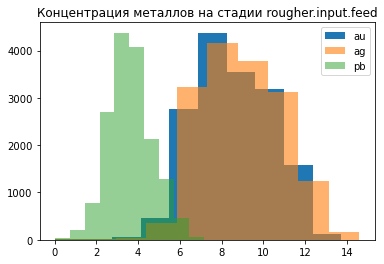

In [33]:
concentration_stage_hist('rougher.input.feed')

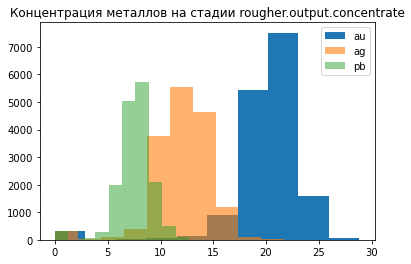

In [34]:
concentration_stage_hist('rougher.output.concentrate') 

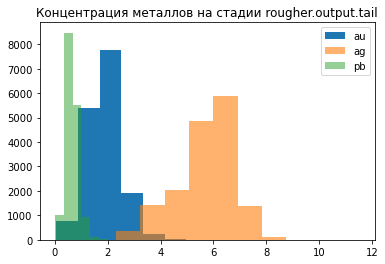

In [35]:
concentration_stage_hist('rougher.output.tail') 

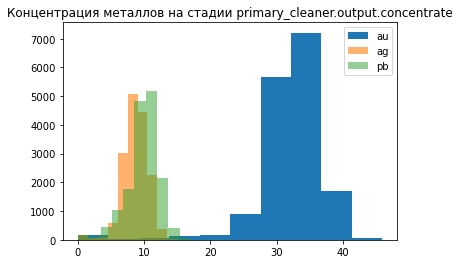

In [36]:
concentration_stage_hist('primary_cleaner.output.concentrate')

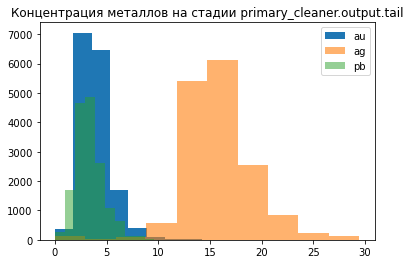

In [37]:
concentration_stage_hist('primary_cleaner.output.tail')

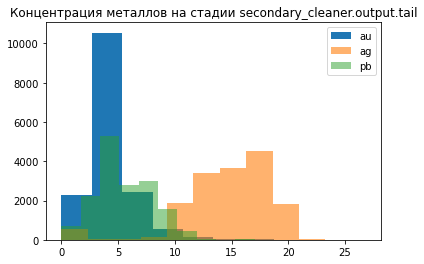

In [38]:
concentration_stage_hist('secondary_cleaner.output.tail')

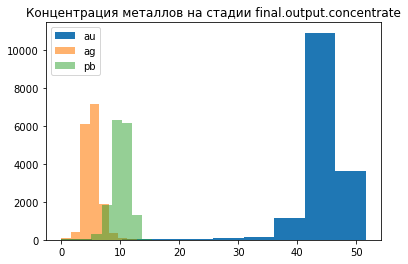

In [39]:
concentration_stage_hist('final.output.concentrate')

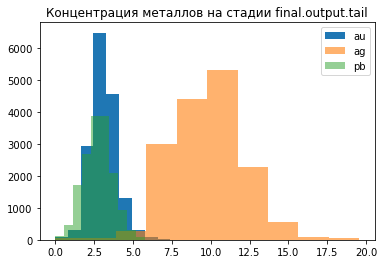

In [40]:
concentration_stage_hist('final.output.tail')

### Распределение гранул сырья

In [41]:
def get_difference_share(variance1, variance2):
    variance_difference = variance1 - variance2
    difference_share = 0
    if variance_difference > 0:
        difference_share = variance2 / variance1
    else:
        difference_share = variance1 / variance2
    return 1 - difference_share

In [42]:
def test_hypothesis(sample1, sample2):
    train_df_revenue_std = sample1.std()
    train_df_revenue_variance = train_df_revenue_std ** 2

    test_df_revenue_std = sample2.std()
    test_df_revenue_variance = test_df_revenue_std ** 2
    
    var_difference_share = get_difference_share(train_df_revenue_variance, test_df_revenue_variance)
    print('Разница дисперсий генеральных совокупностей:', var_difference_share)
    equal_var = var_difference_share < 0.1

    results = ttest_ind(
        sample1,
        sample2,
        equal_var=equal_var
    )

    pvalue = results.pvalue
    print('p-значение', pvalue)

    if pvalue > ALPHA:
          print('Не получилось отвергнуть нулевую гипотезу.')
    else:
        print('Отвергаем нулевую гипотезу.')

In [43]:
# До флотации
rougher_input_feed_size_column = 'rougher.input.feed_size'

train_rougher_input_feed_size = train_df[rougher_input_feed_size_column]
test_rougher_input_feed_size = test_df[rougher_input_feed_size_column]

print('Средний размер гранул сырья в обучающей выборке', train_rougher_input_feed_size.mean())
print('Средний размер гранул сырья в тестовой выборке', test_rougher_input_feed_size.mean())

Средний размер гранул сырья в обучающей выборке 59.98311763589041
Средний размер гранул сырья в тестовой выборке 55.499986625872594


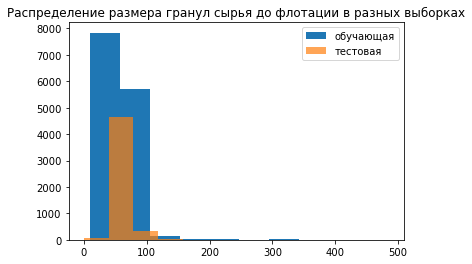

In [44]:
plt.hist(train_rougher_input_feed_size)
plt.hist(test_rougher_input_feed_size, alpha=0.7)

plt.title('Распределение размера гранул сырья до флотации в разных выборках')
plt.legend(labels=['обучающая', 'тестовая'])
plt.show()

Проверим, равны ли значения среднего размера гранул сырья до флотации в обучающей и тестовой выборках

Нулевая гипотеза: значения среднего размера гранул сырья до флотации в обучающей и тестовой выборках равны.

Альтернативная гипотеза: значения среднего размера гранул сырья до флотации в обучающей и тестовой выборках различаются.

In [45]:
test_hypothesis(train_rougher_input_feed_size, test_rougher_input_feed_size)

Разница дисперсий генеральных совокупностей: 0.3548200271762332
p-значение 6.759384774713192e-42
Отвергаем нулевую гипотезу.


p-значение недостаточно велико, что дает основание отвергнуть предположение об отсутвии различий между средними размерами гранул сырья до флотации в обучающей и тестовой выборках.

In [46]:
# После флотации
primary_cleaner_input_feed_size_column = 'primary_cleaner.input.feed_size'

train_primary_cleaner_input_feed_size = train_df[primary_cleaner_input_feed_size_column]
test_primary_cleaner_input_feed_size = test_df[primary_cleaner_input_feed_size_column]

print('Средний размер гранул сырья в обучающей выборке', train_primary_cleaner_input_feed_size.mean())
print('Средний размер гранул сырья в тестовой выборке', test_primary_cleaner_input_feed_size.mean())

Средний размер гранул сырья в обучающей выборке 7.323600740238315
Средний размер гранул сырья в тестовой выборке 7.263431478598125


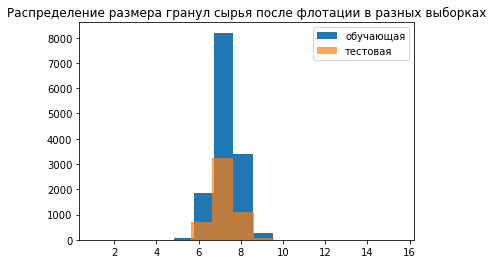

In [47]:
plt.hist(train_primary_cleaner_input_feed_size)
plt.hist(test_primary_cleaner_input_feed_size, alpha=0.7)

plt.title('Распределение размера гранул сырья после флотации в разных выборках')
plt.legend(labels=['обучающая', 'тестовая'])
plt.show()


Проверим, равны ли значения среднего размера гранул сырья в обучающей и тестовой выборках

In [48]:
test_hypothesis(train_primary_cleaner_input_feed_size, test_primary_cleaner_input_feed_size)

Разница дисперсий генеральных совокупностей: 0.04540226944851067
p-значение 1.987756859698579e-09
Отвергаем нулевую гипотезу.


p-значение достаточно велико, что дает основание принять предположение об отсутвии различий между средними размерами гранул сырья после флотации  в обучающей и тестовой выборках.

Средний размер гранул сырья в обучающей и тестовой выборках не имеет существенных различий.

### Суммарная концентрация всех металлов на разных стадиях

In [49]:
full_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16094 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16094 non-null  object 
 1   final.output.concentrate_ag                         16094 non-null  float64
 2   final.output.concentrate_pb                         16094 non-null  float64
 3   final.output.concentrate_sol                        16094 non-null  float64
 4   final.output.concentrate_au                         16094 non-null  float64
 5   final.output.recovery                               16094 non-null  float64
 6   final.output.tail_ag                                16094 non-null  float64
 7   final.output.tail_pb                                16094 non-null  float64
 8   final.output.tail_sol                               16094 non-null  float64


In [50]:
def metals_sum_graph(stage):
    res = au_df[stage] + ag_df[stage] + pb_df[stage] + sol_df[stage]
    plt.hist(res)
    plt.title(f'Суммарная концентрация всех веществ на стадии {stage}')
    plt.show()

In [51]:
stages

['rougher.input.feed',
 'rougher.output.concentrate',
 'rougher.output.tail',
 'primary_cleaner.output.concentrate',
 'primary_cleaner.output.tail',
 'secondary_cleaner.output.tail',
 'final.output.concentrate',
 'final.output.tail']

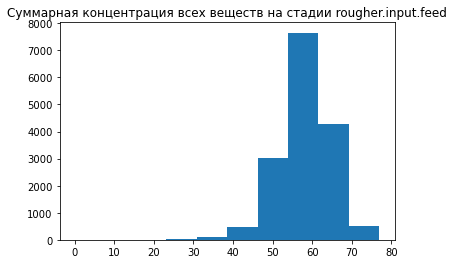

In [52]:
metals_sum_graph('rougher.input.feed')

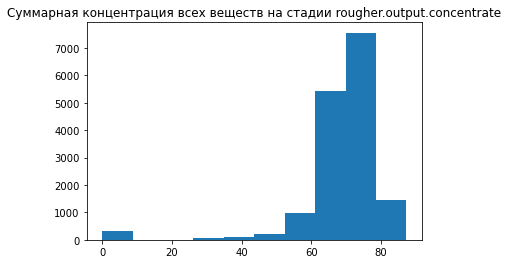

In [53]:
metals_sum_graph('rougher.output.concentrate')

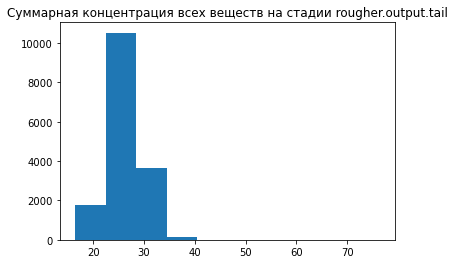

In [54]:
metals_sum_graph('rougher.output.tail')

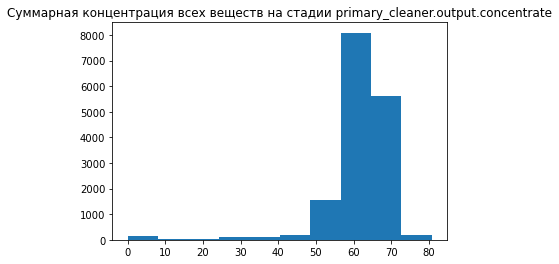

In [55]:
metals_sum_graph('primary_cleaner.output.concentrate')

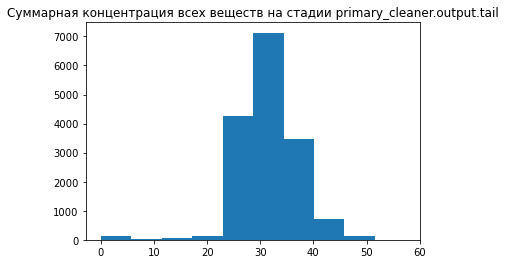

In [56]:
metals_sum_graph('primary_cleaner.output.tail')

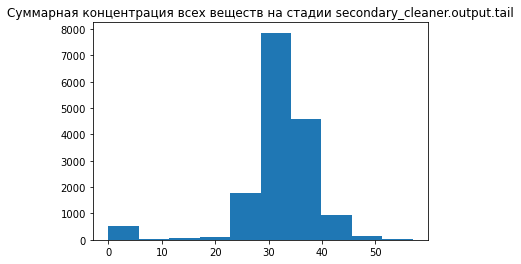

In [57]:
metals_sum_graph('secondary_cleaner.output.tail')

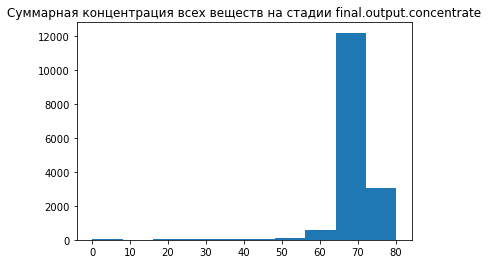

In [58]:
metals_sum_graph('final.output.concentrate')

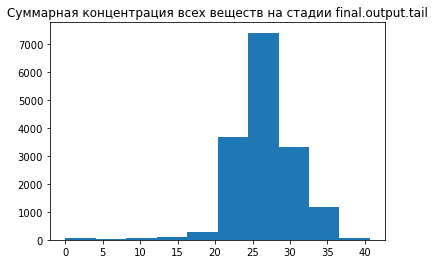

In [59]:
metals_sum_graph('final.output.tail')

metals_sum_graph('final.output.tail')

### Обучение моделей

In [60]:
def smape(target, predicrions):
    nominator = abs(target - predicrions)
    denominator = abs((target + predicrions)) / 2
    res = (nominator / denominator).sum() / target.count() * 100
    return res

In [61]:
def smape_common(smape_rouger, smape_final):
    res = (0.25 * smape_rouger) + (0.75 * smape_final)
    return res

Признак `date` уберем из данных, так как он не несет бизнес-ценности. Также из обучающей выборки выносим целевой признак.

In [62]:
target_rougher_train = train_df['rougher.output.recovery']
target_final_train = train_df['final.output.recovery']
features_train = train_df.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)

print(target_rougher_train.head())
print()
display(target_final_train.head())
features_train.info()


0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64



0    70.541216
1    69.266198
2    68.116445
3    68.347543
4    66.927016
Name: final.output.recovery, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13795 entries, 0 to 14148
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               13795 non-null  float64
 1   primary_cleaner.input.depressant            13795 non-null  float64
 2   primary_cleaner.input.feed_size             13795 non-null  float64
 3   primary_cleaner.input.xanthate              13795 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      13795 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    13795 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      13795 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    13795 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      13795 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    13795 non-null  float64
 10  primary_cl

In [63]:
# Проведем масштабирование признаков
scaler = StandardScaler()
pd.options.mode.chained_assignment = None
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_train = pd.DataFrame(features_train_scaled, columns=features_train.columns)
features_train.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,-0.167502,0.379808,-0.119465,0.280880,-0.447822,-0.287873,-0.430558,-0.810631,-0.435253,-0.260748,...,-1.056288,-0.473270,-0.649345,-0.754089,-1.184768,-0.379789,-0.870197,-0.428884,-0.961637,-2.670300
1,-0.204692,0.429580,-0.119465,0.317786,-0.243388,-0.343242,-0.244610,-0.322199,-0.241538,-0.278893,...,-1.060604,-0.532753,-0.677696,-0.696281,-1.165273,-0.428530,-0.886617,-0.431739,-0.988349,-2.507052
2,-0.250696,0.731853,-0.119465,0.287533,-0.046710,-0.318037,-0.059272,-0.344110,-0.048645,-0.322402,...,-1.056608,-0.473919,-0.684860,-0.692896,-1.159839,-0.427460,-0.881579,-0.430080,-0.983057,-2.551274
3,-0.290094,0.733589,-0.119465,0.302061,-0.059007,-0.344543,-0.057204,-0.316623,-0.061248,-0.318426,...,-1.052830,-0.441101,-0.668394,-0.693926,-1.177092,-0.403152,-0.887903,-0.423360,-0.987092,-2.512685
4,-0.398962,0.908865,-0.119465,0.336914,-0.048387,-0.289632,-0.051299,-0.335707,-0.066605,-0.322908,...,-1.054449,-0.421005,-0.677214,-0.691538,-1.184755,-0.468282,-0.902277,-0.425932,-0.988647,-2.553143


In [64]:
rougher_columns = [
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    'rougher.input.feed_sol',
    'rougher.input.feed_au',
    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate',
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_air',
    'rougher.state.floatbank10_f_level',
]

features_rougher_train = features_train[rougher_columns]
features_rougher_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13795 entries, 0 to 13794
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rougher.input.feed_ag               13795 non-null  float64
 1   rougher.input.feed_pb               13795 non-null  float64
 2   rougher.input.feed_rate             13795 non-null  float64
 3   rougher.input.feed_size             13795 non-null  float64
 4   rougher.input.feed_sol              13795 non-null  float64
 5   rougher.input.feed_au               13795 non-null  float64
 6   rougher.input.floatbank10_sulfate   13795 non-null  float64
 7   rougher.input.floatbank10_xanthate  13795 non-null  float64
 8   rougher.input.floatbank11_sulfate   13795 non-null  float64
 9   rougher.input.floatbank11_xanthate  13795 non-null  float64
 10  rougher.state.floatbank10_a_air     13795 non-null  float64
 11  rougher.state.floatbank10_a_level   13795

In [65]:
best_smape = 0
better_model = None

In [66]:
scorer = make_scorer(smape, greater_is_better=False)

In [67]:
def linear_model(f, t):
    model = LinearRegression()
    model.fit(f, t)
    scores = cross_val_score(model, f, t, cv=5, scoring=scorer) 
    result = abs(sum(scores) / len(scores))
    
    print('result', result)
    return result, model
        

In [68]:
def tree_model(f, t):
    best_result = 0
    best_model = None
    
    for depth in range(1, 20):
        model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=depth)
        model.fit(f, t)
        scores = cross_val_score(model, f, t, cv=5, scoring=scorer) 
        result = abs(sum(scores) / len(scores))
        
        if result > best_result:
            best_result = result
            best_model = model
    
    print('result', result)
    return best_result, best_model

In [69]:
def grid_model(f, t):
    model_forest = RandomForestRegressor()
    params = {
        'max_depth': [randint(1, 100)],
        'n_estimators': [randint(1, 100)],
        'random_state': [RANDOM_STATE],
    }

    grid = GridSearchCV(model_forest, params, scoring=scorer)
    grid.fit(f, t)
    print(grid.best_params_)

In [70]:
def forest_model(f, t, max_depth, n_est):
    model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_est, random_state=RANDOM_STATE)
    model.fit(f, t)
    scores = cross_val_score(model, f, t, cv=5, scoring=scorer) 
    result = abs(sum(scores) / len(scores))
    
    print('result', result)
    return result, model

### rougher.output.recovery

#### Линейная регрессия

In [71]:
result, model = linear_model(features_rougher_train, target_rougher_train)
if result > best_smape:
        best_smape = result
        better_model = model
        print('better model', better_model)

result 6.39299122430251
better model LinearRegression()


#### Дерево решений

In [72]:
result, model = tree_model(features_rougher_train, target_rougher_train)
if result > best_smape:
    best_smape = result
    better_model = model
    print('better model', better_model)

result 9.24240129302217
better model DecisionTreeRegressor(max_depth=16, random_state=12345)


#### Случайный лес

In [73]:
grid_model(features_rougher_train, target_rougher_train)

{'max_depth': 89, 'n_estimators': 20, 'random_state': 12345}


In [74]:
result, model = forest_model(features_rougher_train, target_rougher_train, 79, 67)
if result > best_smape:
    best_smape = result
    better_model = model
    print('better model', better_model)

result 6.866125656898906


### final.output.recovery 

#### Линейная регрессия

In [75]:
result, model = linear_model(features_train, target_final_train)
if result > best_smape:
        best_smape = result
        better_model = model
        print('better model', better_model)

result 10.972158672717873
better model LinearRegression()


#### Дерево решений

In [76]:
result, model = tree_model(features_train, target_final_train)
if result > best_smape:
    best_smape = result
    better_model = model
    print('better model', better_model)

result 15.985685918123163
better model DecisionTreeRegressor(max_depth=16, random_state=12345)


#### Случайный лес

In [77]:
grid_model(features_train, target_final_train)

{'max_depth': 95, 'n_estimators': 78, 'random_state': 12345}


In [78]:
result, model = forest_model(features_train, target_final_train, 18, 89)
if result > best_smape:
    best_smape = result
    better_model = model
    print('better model', better_model)

result 9.838806495745942


### Проверка модели

In [79]:
target_rougher_test = test_df['rougher.output.recovery']
target_final_test = test_df['final.output.recovery']
features_test = test_df.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)

print(target_rougher_test.head())
print()
print(target_final_test.head())
features_test.info()

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64

0    70.541216
1    69.266198
2    68.116445
3    68.347543
4    66.927016
Name: final.output.recovery, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5113 entries, 0 to 5289
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5113 non-null   float64
 1   primary_cleaner.input.depressant            5113 non-null   float64
 2   primary_cleaner.input.feed_size             5113 non-null   float64
 3   primary_cleaner.input.xanthate              5113 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5113 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5113 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5113 non-null   flo

In [80]:
# Проведем масштабирование признаков
scaler = StandardScaler()
pd.options.mode.chained_assignment = None
scaler.fit(features_test)
features_test_scaled = scaler.transform(features_test)
features_test = pd.DataFrame(features_test_scaled, columns=features_test.columns)
features_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,0.841710,2.066382,1.356654,-0.606073,-1.262808,-0.135586,-1.242071,0.001613,-1.095795,-0.113443,...,-1.223811,0.235166,-1.668448,-0.438161,-1.621905,4.160848,-1.760821,-0.134882,2.057604,0.050213
1,0.951323,2.064529,1.356654,-0.628707,-1.264628,-0.126355,-1.251269,0.006316,-1.129333,-0.041665,...,-1.213839,0.205959,-1.635080,-0.416811,-1.618040,-1.493103,-1.758614,-0.138540,1.683941,0.047399
2,0.948159,1.374346,0.869308,-0.620037,-1.267171,-0.170873,-1.244473,0.006770,-1.112999,-0.184385,...,-1.241452,0.203632,-1.645029,-0.432204,-1.580808,0.020592,-1.749469,-0.128765,1.678383,0.026857
3,0.949980,1.086091,0.625634,-0.826174,-1.257111,-0.060816,-1.256462,0.025160,-1.095572,0.001685,...,-1.221061,0.217151,-1.651435,-0.414749,-1.638238,0.016551,-1.740324,-0.132721,1.668200,0.075777
4,0.562362,0.651382,0.442879,-0.916294,-1.242349,-0.167576,-1.250649,0.015408,-1.078235,-0.118651,...,-1.223288,0.138107,-1.657350,-0.426658,-1.568648,-0.506889,-1.731178,-0.144326,1.680260,0.020877


#### rougher

In [81]:
features_rougher_test = features_test[rougher_columns]
features_rougher_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5113 entries, 0 to 5112
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rougher.input.feed_ag               5113 non-null   float64
 1   rougher.input.feed_pb               5113 non-null   float64
 2   rougher.input.feed_rate             5113 non-null   float64
 3   rougher.input.feed_size             5113 non-null   float64
 4   rougher.input.feed_sol              5113 non-null   float64
 5   rougher.input.feed_au               5113 non-null   float64
 6   rougher.input.floatbank10_sulfate   5113 non-null   float64
 7   rougher.input.floatbank10_xanthate  5113 non-null   float64
 8   rougher.input.floatbank11_sulfate   5113 non-null   float64
 9   rougher.input.floatbank11_xanthate  5113 non-null   float64
 10  rougher.state.floatbank10_a_air     5113 non-null   float64
 11  rougher.state.floatbank10_a_level   5113 no

In [82]:
better_model

DecisionTreeRegressor(max_depth=16, random_state=12345)

In [83]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=16)
model.fit(features_rougher_test, target_rougher_test)
scores = cross_val_score(model, features_rougher_test, target_rougher_test, cv=5, scoring=scorer) 
rougher_smape = abs(sum(scores) / len(scores))
rougher_smape

11.354616178522996

#### Финальный результат

In [84]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=16)
model.fit(features_test, target_final_test)
scores = cross_val_score(model, features_test, target_final_test, cv=5, scoring=scorer) 
final_smape = abs(sum(scores) / len(scores))
final_smape

18.134543822127085

<div class="alert alert-info">
<b>👂 Совет:</b> Для данного проекта неактуально, но модели scikit-learn могут обучать сразу несколько тагретов, если таргет передавать не в виде вектора, а в виде таблицы. Тогда можно будет один раз прогнать модель через кросс-валидацию. Правда придется в качестве scorer использовать smape_final, переписав ее в таком духе:
    
</div>

```python
def smape_final(target, predictions):
    smape_rougher = smape(target[0], predictions[0])
    smape_final = smape(target[1], predictions[1])
    ...
    ...
```

### Итоговое smape

In [85]:
smape_common_value = smape_common(rougher_smape, final_smape)
smape_common_value

16.439561911226065

Финальное значение Smape равно 16.44